# Cellpose Segmentation

In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scportrait.pipeline.featurization import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose
from scportrait.pipeline.selection import LMDSelection

/Users/sophia/mambaforge/envs/scportrait_test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_location = "project"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example1.yml",
    overwrite=True,
    debug=True,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Updating project config file.
[27/02/2025 17:58:24] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/config.yml
[27/02/2025 17:58:24] Compression algorithm for extracted single-cell images: lzf
[27/02/2025 17:58:24] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1.


In [3]:
from scportrait.data._datasets import dataset_1

dataset_1_path = dataset_1()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_1_path}/Ch1.tif", f"{dataset_1_path}/Ch2.tif", f"{dataset_1_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

[27/02/2025 17:58:24] Output location /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/scportrait
         .sdata                                                                                                    
[27/02/2025 17:58:24] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_9l0_mtot for Project
[27/02/2025 17:58:25] Image input_image written to sdata object.
[27/02/2025 17:58:25] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_9l0_mtot'>


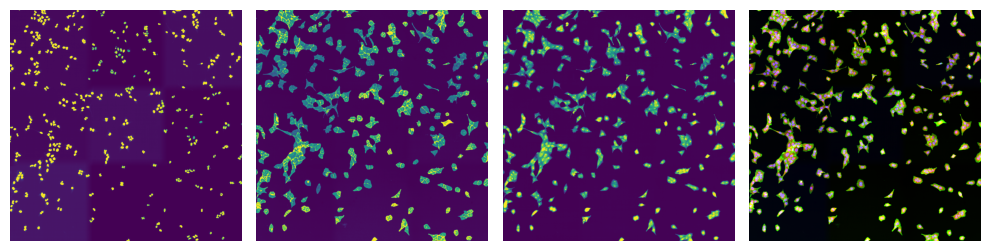

In [ ]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

from scportrait.plotting.vis import generate_composite

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

[27/02/2025 17:58:29] GPU Status for segmentation is True and will segment using the following device mps.
[27/02/2025 17:58:29] Segmenting nucleus using the following model: nuclei
[27/02/2025 17:58:36] Segmenting cytosol using the following model: cyto2
[27/02/2025 17:58:48] Performing filtering to match Cytosol and Nucleus IDs.
[27/02/2025 17:59:01] Removed 132 nuclei and 59 cytosols due to filtering.
[27/02/2025 17:59:01] After filtering, 394 matching nuclei and cytosol masks remain.
[27/02/2025 17:59:05] Total time to perform nucleus and cytosol mask matching filtering: 16.99 seconds
[27/02/2025 17:59:05] Segmentation seg_all_nucleus written to sdata object.
[27/02/2025 17:59:07] Points centers_seg_all_nucleus written to sdata object.
[27/02/2025 17:59:07] Segmentation seg_all_cytosol written to sdata object.
[27/02/2025 17:59:07] Points centers_seg_all_cytosol written to sdata object.


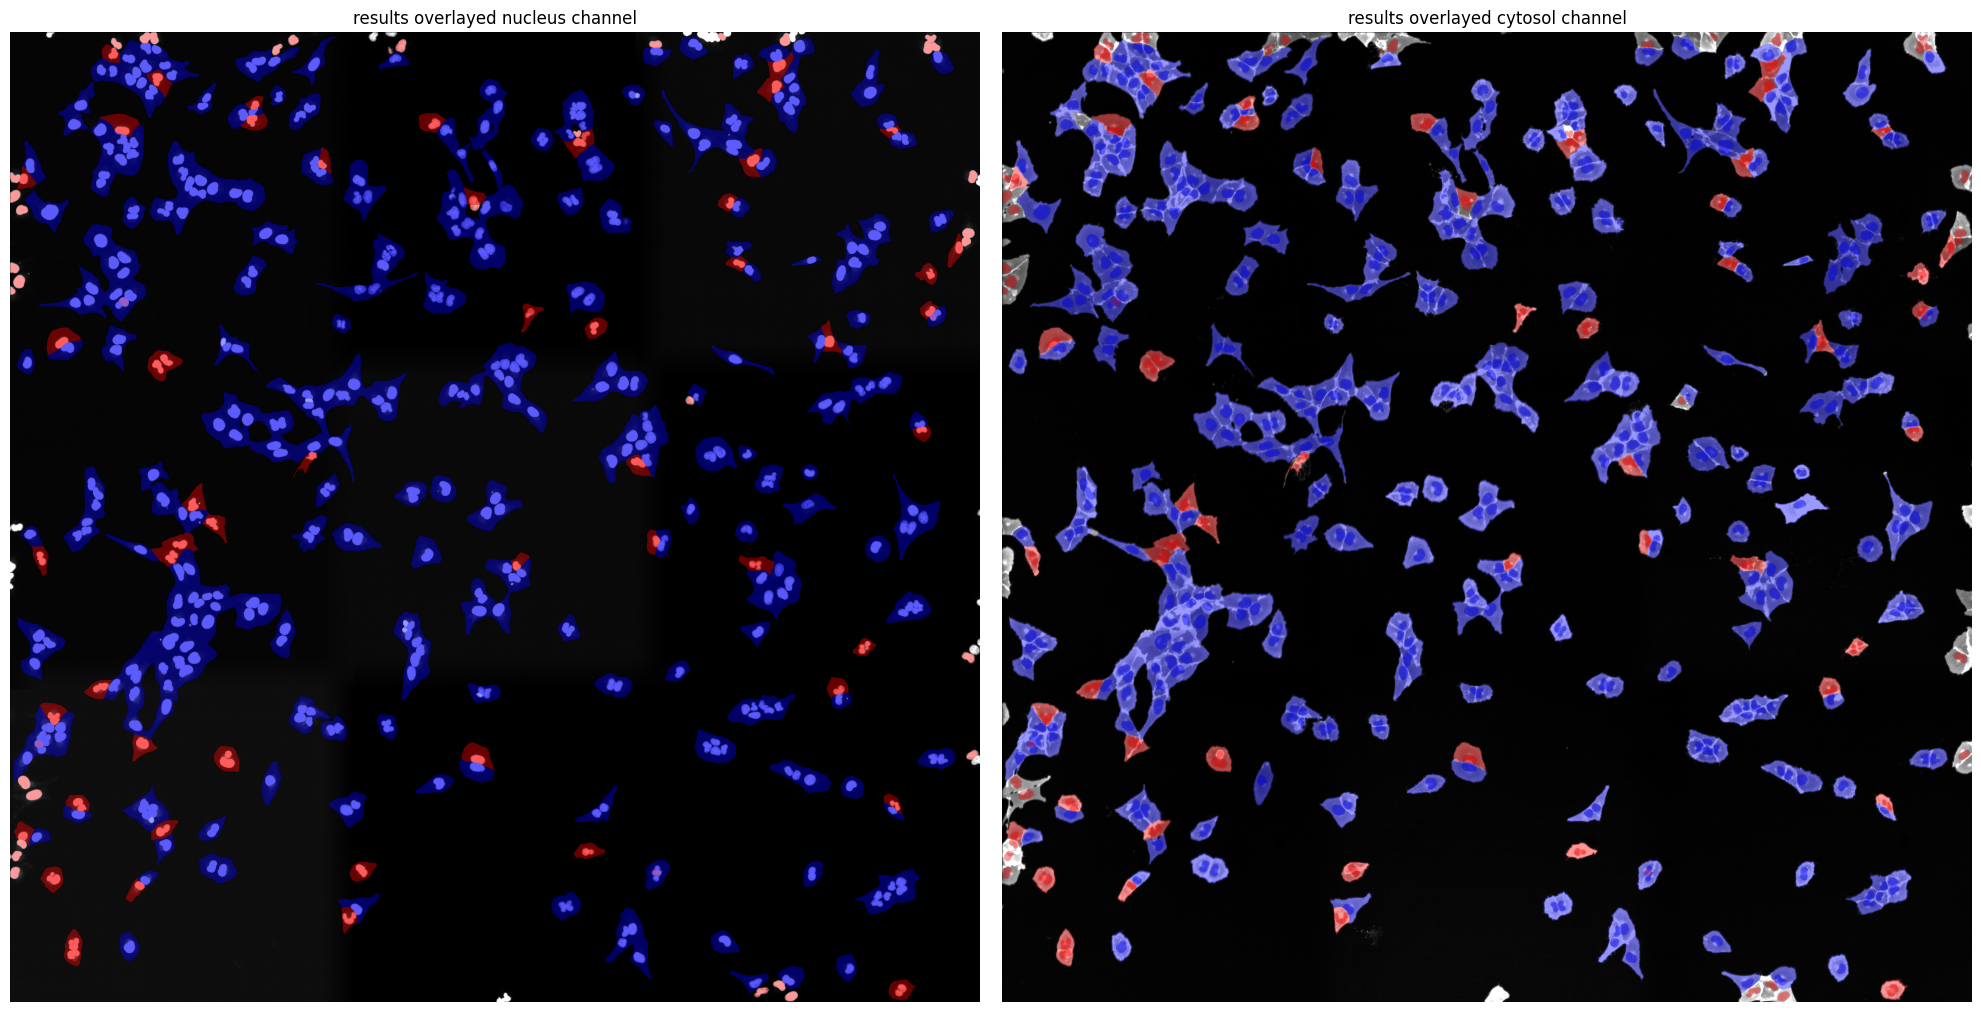

In [5]:
project.segment()

(-0.5, 3036.5, 3038.5, -0.5)

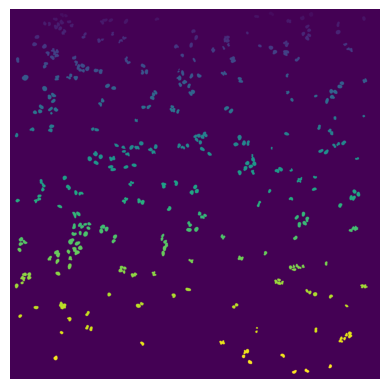

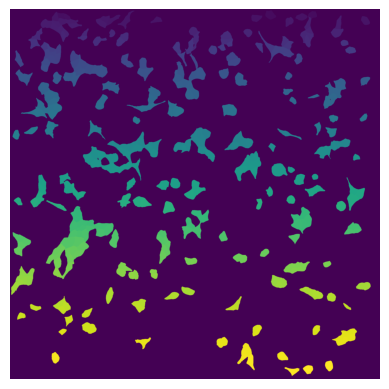

In [6]:
plt.figure()
plt.imshow(project.sdata["seg_all_nucleus"])
plt.axis("off")

plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

In [7]:
project.extract()

[27/02/2025 17:59:15] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/HDF5CellExtraction_4v45n5p2 for HDF5CellExtraction
[27/02/2025 17:59:15] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extraction/data
[27/02/2025 17:59:15] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extraction/data
[27/02/2025 17:59:15] Found 2 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_nucleus', 'seg_all_cytosol']
[27/02/2025 17:59:15] Using seg_all_nucleus as the main segmentation mask to determine cell centers.
[27/02/2025 17:59:15] A total of 10 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/pr

Extracting cell batches: 100%|██████████| 4/4 [00:00<00:00, 11.75it/s]


[27/02/2025 17:59:16] Finished extraction in 0.61 seconds (634.47 cells / second)
[27/02/2025 17:59:16] Benchmarking times saved to file.
[27/02/2025 17:59:16] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/HDF5CellExtraction_4v45n5p2'>


(384, 5, 128, 128)


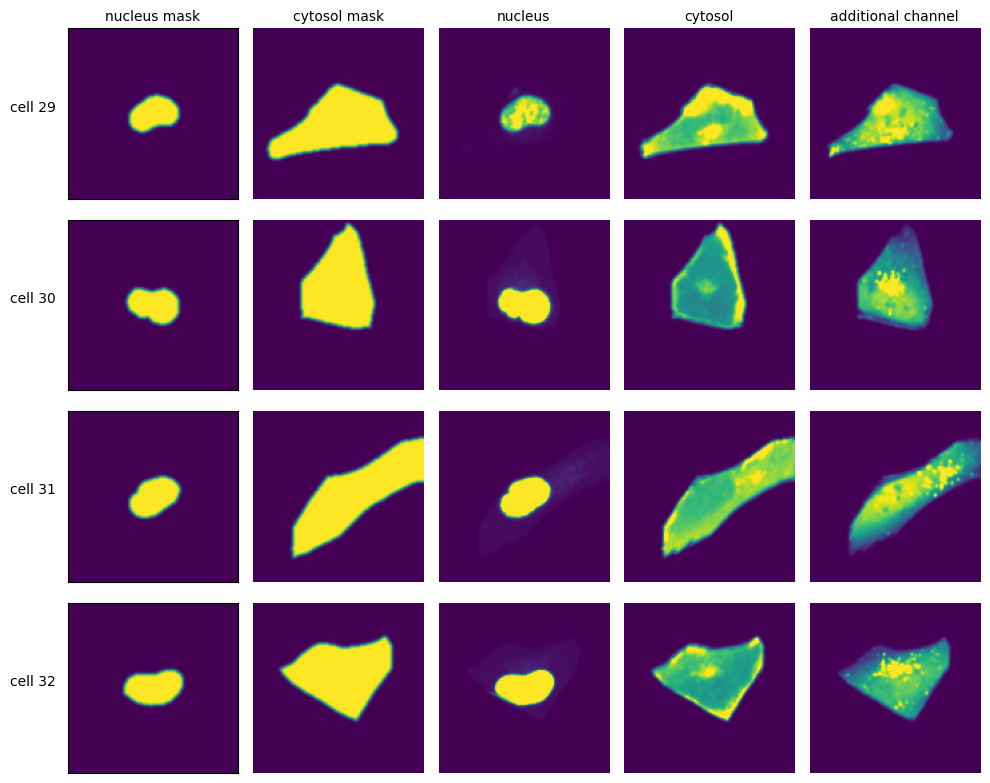

In [8]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize=(5 * 2, len(n_cells) * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)
    fig.tight_layout()

In [9]:
project.featurize()

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extraction/data/single_cells.h5
[27/02/2025 17:59:17] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/CellFeaturizer_20amadj7 for CellFeaturizer
[27/02/2025 17:59:17] Started CellFeaturization of all available channels.
[27/02/2025 17:59:17] Overwrite flag is set, deleting existing directory for featurization results.
[27/02/2025 17:59:17] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/featurization/complete_CellFeaturizer
[27/02/2025 17:59:17] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[27/02/2025 17:59:17] Reading data from path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/extract

In [10]:
# load classification results
results = pd.read_csv(f"{project_location}/featurization/complete_CellFeaturizer/calculated_image_features.csv")
results

,nucleus_area,cytosol_area,cytosol_only_area,1_mean_nucleus,1_median_nucleus,1_quant75_nucleus,1_quant25_nucleus,1_summed_intensity_nucleus,1_summed_intensity_area_normalized_nucleus,1_mean_cytosol,...,3_summed_intensity_cytosol,3_summed_intensity_area_normalized_cytosol,3_mean_cytosol_only,3_median_cytosol_only,3_quant75_cytosol_only,3_quant25_cytosol_only,3_summed_intensity_cytosol_only,3_summed_intensity_area_normalized_cytosol_only,label,cell_id
0,1667.0,5229.0,3562.0,0.076646,0.0,0.019680,0.0,1255.77280,0.352547,0.076646,...,2538.0574,0.712537,0.154911,0.0,3.311920e-02,0.0,2538.0574,0.712537,0,27
1,1389.0,4986.0,3597.0,0.062219,0.0,0.005716,0.0,1019.39810,0.283402,0.062219,...,2729.7373,0.758893,0.166610,0.0,2.770424e-03,0.0,2729.7373,0.758893,0,28
2,1279.0,4210.0,2931.0,0.040158,0.0,0.000000,0.0,657.94460,0.224478,0.040158,...,1901.5627,0.648776,0.116062,0.0,1.192093e-07,0.0,1901.5627,0.648776,0,29
3,1379.0,3974.0,2595.0,0.055688,0.0,0.000000,0.0,912.39030,0.351596,0.055688,...,1703.2892,0.656374,0.103961,0.0,0.000000e+00,0.0,1703.2892,0.656374,0,30
4,1391.0,4922.0,3531.0,0.057353,0.0,0.001249,0.0,939.67834,0.266122,0.057353,...,2136.5999,0.605098,0.130408,0.0,1.899481e-03,0.0,2136.5999,0.605098,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,1123.0,4138.0,3015.0,0.034690,0.0,0.000000,0.0,568.36743,0.188513,0.034690,...,1565.2190,0.519144,0.095533,0.0,0.000000e+00,0.0,1565.2190,0.519144,0,529
380,1571.0,5734.0,4163.0,0.077212,0.0,0.053429,0.0,1265.04690,0.303879,0.077212,...,2282.1113,0.548189,0.139289,0.0,8.972168e-03,0.0,2282.1113,0.548189,0,531
381,1487.0,6115.0,4628.0,0.055157,0.0,0.002697,0.0,903.69507,0.195267,0.055157,...,2239.8726,0.483983,0.136711,0.0,6.579590e-02,0.0,2239.8726,0.483983,0,535
382,1195.0,5578.0,4383.0,0.038588,0.0,0.001783,0.0,632.22565,0.144245,0.038588,...,2038.9376,0.465192,0.124447,0.0,1.148605e-02,0.0,2038.9376,0.465192,0,536


In [11]:
#test selection workflow
selected_cells_large = results[results.cytosol_area > 4500]["cell_id"].tolist()
selected_cells_small = results[results.cytosol_area < 3000]["cell_id"].tolist()

cells_to_select = [
    {"name": "large_cells", "classes": selected_cells_large, "well": "A1"},
    {"name": "small_cells", "classes": selected_cells_small, "well": "B1"},
]

marker_0 = (0, 0)
marker_1 = (2000, 0)
marker_2 = (0, 2000)

calibration_marker = np.array([marker_0, marker_1, marker_2])


[27/02/2025 17:59:24] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/LMDSelection_u5rrlsej for LMDSelection
[27/02/2025 17:59:24] Selection process started.


Processing cell batches: 100%|██████████| 3/3 [00:08<00:00,  2.76s/it]


[27/02/2025 17:59:33] Temporary directory not found, skipping cleanup
[27/02/2025 17:59:33] Temporary directory not found, skipping cleanup
[27/02/2025 17:59:33] Temporary directory not found, skipping cleanup
[27/02/2025 17:59:34] Coordinate lookup index calculation took 10.04622200038284 seconds.
No configuration for shape_erosion found, parameter will be set to 0
No configuration for binary_smoothing found, parameter will be set to 3
No configuration for convolution_smoothing found, parameter will be set to 15
No configuration for rdp_epsilon found, parameter will be set to 0.1
No configuration for xml_decimal_transform found, parameter will be set to 100
No configuration for distance_heuristic found, parameter will be set to 300
No configuration for join_intersecting found, parameter will be set to True
Path optimizer used for XML generation: hilbert
cell set 0 passed sanity check
cell set 1 passed sanity check
Loading coordinates from external source
Processing cell sets in parall

dilating shapes: 100%|██████████| 176/176 [00:07<00:00, 24.15it/s]


0 shapes that were intersecting were found and merged.


creating shapes:   0%|          | 0/30 [00:00<?, ?it/s]

0 shapes that were intersecting were found and merged.


calculating polygons: 100%|██████████| 30/30 [00:08<00:00,  3.70it/s]


Current path length: 30,571.59 units
Optimized path length: 14,445.59 units
Optimization factor: 2.1x


calculating polygons:   1%|          | 1/109 [00:05<09:04,  5.04s/it]

Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets:  50%|█████     | 1/2 [00:25<00:25, 25.50s/it]

calculating polygons: 100%|██████████| 109/109 [00:08<00:00, 13.39it/s]


Current path length: 101,944.11 units
Optimized path length: 29,672.85 units
Optimization factor: 3.4x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets: 100%|██████████| 2/2 [00:29<00:00, 14.70s/it]


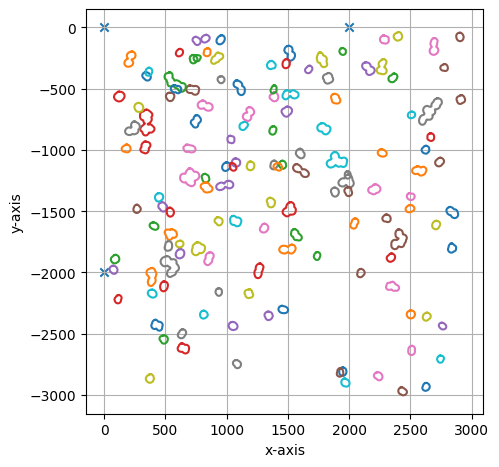

===== Collection Stats =====
Number of shapes: 139
Number of vertices: 10,939
Mean vertices: 79
Min vertices: 54
5% percentile vertices: 58
Median vertices: 67
95% percentile vertices: 120
Max vertices: 206
[0 0]
[      0 -200000]
[200000      0]
[27/02/2025 18:00:04] Saved output at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project/selection/large_cells_small_cells.xml
[27/02/2025 18:00:05] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/LMDSelection_u5rrlsej'>


In [12]:
project.select(cells_to_select, calibration_marker)